# Lab: Schelling Model and its variants

The Schelling Model of Segregation, introduced by Thomas Schelling in the 1970s, is a foundational agent-based model used to study how local preferences can lead to large-scale spatial segregation, even when individuals only have mild biases. In the model, agents of different types (e.g., colors or groups) occupy a grid and move if their local neighborhood does not meet a certain satisfaction threshold—typically based on the proportion of similar neighbors. Despite its simplicity, the Schelling model reveals powerful insights about emergent collective behavior and is widely used in fields such as economics, sociology, and urban studies.

In this lab, we will implement and explore several key variants of the Schelling model to understand how changes in assumptions or rules can alter the system’s dynamics and outcomes. 

## Before We Start: Building a Flexible Framework

To systematically explore the Schelling model and its variants, we start by **decomposing the model into modular components**. This helps us better understand how individual choices and system rules affect emergent patterns.

We identify the following key components:

- **Initialization strategies**: how the city and agents are initially distributed  
  – *e.g.*, random placement, balanced layout, half-full blocks

- **Agent selection**: which agent moves next  
  – *e.g.*, random agent, agent with lowest utility

- **Target selection**: where the agent may want to move  
  – *e.g.*, random vacant cell, block with highest utility

- **Move acceptance rule**: when a move is allowed  
  – *e.g.*, only if personal utility increases, or social welfare increases, or via Metropolis-Hastings

- **Stopping criteria**: when to halt the simulation  
  – *e.g.*, fixed number of steps, or no more accepted moves

## A Simple Baseline Implementation

We now provide a basic implementation of this modular framework. You can think of this as a **template**, where different strategies can be plugged in to explore different behaviors.

This baseline version implements:

- A **random initialization** of agents across neighborhoods  
- A **random agent selection**  
- A **random target selection**  
- A **greedy acceptance rule**: only accept moves that improve individual utility
- A **fixed step stop criterion**

The goal here is to get familiar with the **basic data structures and control flow**.

### Project Structure and Baseline Overview

Our implementation is organized as a modular package `schelling/`, where each component of the simulation is separated into its own file. This makes it easier to understand, maintain, and extend.

Our codebase is organized into modular components. Each file contains one specific type of strategy or helper function. This design makes it easy to swap in new behaviors and explore different variants of the Schelling model.

- `initialization.py`: defines how agents are initially placed in the city
- `agent_selector.py`: strategy for choosing which agent moves
- `target_selector.py`: strategy for choosing where the agent might move
- `move_acceptor.py`: rule for deciding whether a move is accepted
- `stop_criterion.py`: determines when to stop the simulation
- `utils.py`: shared utility functions and plotting tools

Each module provides a **baseline implementation** that is simple but functional. You can find them in the respective `.py` files.

In the next cells, we will import and run the baseline strategy to demonstrate how the system works.

In [47]:
%load_ext autoreload
%autoreload 2
from schelling import *
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# === Parameters ===
Q = 36        # number of neighborhoods
H = 100        # capacity per block
rho0 = 0.5    # initial global density
max_steps = 100000

# === Initialize ===
occupied = initialization.init_random(Q, H, rho0)
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')


In [ ]:

# === Main loop ===
step = 0
while True:
    # Stopping criterion
    if stop_criterion.stop_after_fixed_steps(step, max_steps):
        print(f"Stopped at step {step}")
        break

    # 1. Select an agent block (weighted by number of agents)
    from_block = agent_selector.select_agent_random(occupied)

    # 2. Select a target block (must have space)
    to_block = target_selector.select_target_random_cell(occupied, H)

    # 3. Check if move is accepted (Δu > 0)
    if move_acceptor.accept_if_personal_utility_improves(occupied[from_block] / H, (occupied[to_block] + 1) / H, utils.triangle_utility):
        occupied[from_block] -= 1
        occupied[to_block] += 1
    step += 1

In [ ]:
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')

## Competition between collective and individual dynamics
The central question of this paper is: **How does individual decision-making, when partially weighted by collective welfare, drive a transition from an inefficient segregated state to an efficient mixed state at the macro level?** 

Within a Schelling-like city-block model, the authors introduce a parameter $\alpha$ that interpolates between purely selfish behavior ($\Delta u$) and purely collective-oriented behavior ($\Delta U$). They construct a *link function* that bridges individual and collective utilities, effectively defining an analytically tractable potential (or quasi-free energy) for the system. This formulation allows them to systematically study how cooperation level $\alpha$, utility asymmetry $m$, and temperature $T$ influence the steady state. The paper derives analytical thresholds—such as $\alpha_c = 1 / (3 - 2m)$—and predicts the steady-state configurations, providing a clear theoretical understanding of the transition between segregation and mixing.

### Main Difference from the Baseline under Our Framework

Within our modular framework, the most significant departure from the baseline implementation lies in the **move acceptance rule**. 

In the baseline model, an agent’s move is typically accepted **only if it strictly increases the agent’s own utility** — a purely selfish decision criterion. In contrast, the variant proposed in the paper introduces a *blended acceptance rule* parameterized by $\alpha$, where the decision is based on a weighted combination of **individual utility change** $\Delta u$ and **global utility change** $\Delta U$. This allows agents to partially incorporate collective welfare into their decisions, enabling the model to capture a continuum of behaviors between purely selfish and purely cooperative dynamics, and to study how varying $\alpha$ impacts the system’s steady-state patterns.

In [48]:
# === Parameters ===
Q = 36        # number of neighborhoods
H = 100        # capacity per block
rho0 = 0.5    # initial global density
max_steps = 100000
m = 0.0
alpha = 0.0
T = 0.01

In [49]:
def version_1(Q, H, rho0, max_steps, m, alpha, T, m_tab = None, utility_func=None):
    # === Initialize ===
    occupied = initialization.init_random(Q, H, rho0)
    # utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')
    # === Main loop ===
    if utility_func is None:
        utility_func = lambda x: utils.asymmetric_triangle_utility(x, right_y=m)        

    step = 0
    while True:
        # Stopping criterion
        if stop_criterion.stop_after_fixed_steps(step, max_steps):
            print(f"Stopped at step {step}")
            break

        # 1. Select an agent block (weighted by number of agents)
        from_block = agent_selector.select_agent_random(occupied)

        # 2. Select a target block (must have space)
        to_block = target_selector.select_target_random_cell(occupied, H)

        # 3. Check if move is accepted (Δu > 0)
        if move_acceptor.accept_metropolis(from_block, to_block, occupied, H, utility_func, alpha, T, m_tab):
            occupied[from_block] -= 1
            occupied[to_block] += 1
        step += 1
        
    return occupied

In [50]:
alphas = [i / 10 for _ in range(11) for i in range(11)]
ms = [i / 10 for i in range(11) for _ in range(11)]
us = []
N = Q * H * rho0
from tqdm import tqdm
# print(m_tab)
for i in tqdm(range(len(alphas))):
    m = ms[i]
    alpha = alphas[i]
    utility_func = lambda x: utils.asymmetric_triangle_utility(x, right_y=m)
    m_tab = move_acceptor.build_marginal_table(H, utility_func)
    occupied = version_1(Q, H, rho0, max_steps, m, alpha, T, m_tab)
    u = np.sum(utility_func(occupied / H) * occupied) / N
    us.append(u)
    # print(PoA)



  1%|          | 1/121 [00:03<07:08,  3.57s/it]

Stopped at step 100000


  2%|▏         | 2/121 [00:07<07:08,  3.60s/it]

Stopped at step 100000


  2%|▏         | 3/121 [00:10<07:04,  3.59s/it]

Stopped at step 100000


  3%|▎         | 4/121 [00:14<06:59,  3.58s/it]

Stopped at step 100000


  4%|▍         | 5/121 [00:17<06:55,  3.58s/it]

Stopped at step 100000


  5%|▍         | 6/121 [00:22<07:21,  3.84s/it]

Stopped at step 100000


  6%|▌         | 7/121 [00:26<07:14,  3.81s/it]

Stopped at step 100000


  7%|▋         | 8/121 [00:29<07:06,  3.78s/it]

Stopped at step 100000


  7%|▋         | 9/121 [00:33<06:56,  3.72s/it]

Stopped at step 100000


  8%|▊         | 10/121 [00:36<06:48,  3.68s/it]

Stopped at step 100000


  9%|▉         | 11/121 [00:40<06:42,  3.66s/it]

Stopped at step 100000


 10%|▉         | 12/121 [00:44<06:34,  3.62s/it]

Stopped at step 100000


 11%|█         | 13/121 [00:47<06:31,  3.62s/it]

Stopped at step 100000


 12%|█▏        | 14/121 [00:51<06:26,  3.61s/it]

Stopped at step 100000


 12%|█▏        | 15/121 [00:54<06:23,  3.62s/it]

Stopped at step 100000


 13%|█▎        | 16/121 [00:58<06:18,  3.61s/it]

Stopped at step 100000


 14%|█▍        | 17/121 [01:02<06:14,  3.60s/it]

Stopped at step 100000


 15%|█▍        | 18/121 [01:05<06:10,  3.60s/it]

Stopped at step 100000


 16%|█▌        | 19/121 [01:09<06:08,  3.61s/it]

Stopped at step 100000


 17%|█▋        | 20/121 [01:12<06:03,  3.60s/it]

Stopped at step 100000


 17%|█▋        | 21/121 [01:16<06:00,  3.60s/it]

Stopped at step 100000


 18%|█▊        | 22/121 [01:20<05:55,  3.59s/it]

Stopped at step 100000


 19%|█▉        | 23/121 [01:23<05:50,  3.58s/it]

Stopped at step 100000


 20%|█▉        | 24/121 [01:27<05:47,  3.58s/it]

Stopped at step 100000


 21%|██        | 25/121 [01:30<05:46,  3.61s/it]

Stopped at step 100000


 21%|██▏       | 26/121 [01:34<05:45,  3.63s/it]

Stopped at step 100000


 22%|██▏       | 27/121 [01:38<05:41,  3.64s/it]

Stopped at step 100000


 23%|██▎       | 28/121 [01:41<05:39,  3.65s/it]

Stopped at step 100000


 24%|██▍       | 29/121 [01:45<05:34,  3.64s/it]

Stopped at step 100000


 25%|██▍       | 30/121 [01:49<05:29,  3.62s/it]

Stopped at step 100000


 26%|██▌       | 31/121 [01:52<05:25,  3.62s/it]

Stopped at step 100000


 26%|██▋       | 32/121 [01:56<05:21,  3.61s/it]

Stopped at step 100000


 27%|██▋       | 33/121 [01:59<05:18,  3.62s/it]

Stopped at step 100000


 28%|██▊       | 34/121 [02:03<05:12,  3.59s/it]

Stopped at step 100000


 29%|██▉       | 35/121 [02:07<05:09,  3.60s/it]

Stopped at step 100000


 30%|██▉       | 36/121 [02:10<05:06,  3.60s/it]

Stopped at step 100000


 31%|███       | 37/121 [02:14<05:03,  3.61s/it]

Stopped at step 100000


 31%|███▏      | 38/121 [02:17<04:59,  3.61s/it]

Stopped at step 100000


 32%|███▏      | 39/121 [02:21<04:56,  3.61s/it]

Stopped at step 100000


 33%|███▎      | 40/121 [02:25<04:52,  3.61s/it]

Stopped at step 100000


 34%|███▍      | 41/121 [02:28<04:51,  3.65s/it]

Stopped at step 100000


 35%|███▍      | 42/121 [02:32<04:47,  3.64s/it]

Stopped at step 100000


 36%|███▌      | 43/121 [02:36<04:43,  3.63s/it]

Stopped at step 100000


 36%|███▋      | 44/121 [02:39<04:41,  3.65s/it]

Stopped at step 100000


 37%|███▋      | 45/121 [02:43<04:37,  3.65s/it]

Stopped at step 100000


 38%|███▊      | 46/121 [02:47<04:33,  3.64s/it]

Stopped at step 100000


 39%|███▉      | 47/121 [02:50<04:29,  3.64s/it]

Stopped at step 100000


 40%|███▉      | 48/121 [02:54<04:26,  3.65s/it]

Stopped at step 100000


 40%|████      | 49/121 [02:59<04:45,  3.97s/it]

Stopped at step 100000


 41%|████▏     | 50/121 [03:02<04:34,  3.87s/it]

Stopped at step 100000


 42%|████▏     | 51/121 [03:06<04:25,  3.79s/it]

Stopped at step 100000


 43%|████▎     | 52/121 [03:09<04:17,  3.73s/it]

Stopped at step 100000


 44%|████▍     | 53/121 [03:13<04:11,  3.70s/it]

Stopped at step 100000


 45%|████▍     | 54/121 [03:17<04:08,  3.71s/it]

Stopped at step 100000


 45%|████▌     | 55/121 [03:21<04:07,  3.75s/it]

Stopped at step 100000


 46%|████▋     | 56/121 [03:24<04:05,  3.78s/it]

Stopped at step 100000


 47%|████▋     | 57/121 [03:28<04:00,  3.76s/it]

Stopped at step 100000


 48%|████▊     | 58/121 [03:32<03:54,  3.72s/it]

Stopped at step 100000


 49%|████▉     | 59/121 [03:35<03:48,  3.69s/it]

Stopped at step 100000


 50%|████▉     | 60/121 [03:39<03:43,  3.67s/it]

Stopped at step 100000


 50%|█████     | 61/121 [03:43<03:39,  3.65s/it]

Stopped at step 100000


 51%|█████     | 62/121 [03:46<03:34,  3.64s/it]

Stopped at step 100000


 52%|█████▏    | 63/121 [03:50<03:30,  3.63s/it]

Stopped at step 100000


 53%|█████▎    | 64/121 [03:53<03:26,  3.62s/it]

Stopped at step 100000


 54%|█████▎    | 65/121 [03:57<03:22,  3.62s/it]

Stopped at step 100000


 55%|█████▍    | 66/121 [04:01<03:18,  3.62s/it]

Stopped at step 100000


 55%|█████▌    | 67/121 [04:04<03:13,  3.59s/it]

Stopped at step 100000


 56%|█████▌    | 68/121 [04:08<03:13,  3.65s/it]

Stopped at step 100000


 57%|█████▋    | 69/121 [04:12<03:09,  3.64s/it]

Stopped at step 100000


 58%|█████▊    | 70/121 [04:15<03:05,  3.64s/it]

Stopped at step 100000


 59%|█████▊    | 71/121 [04:19<03:01,  3.63s/it]

Stopped at step 100000


 60%|█████▉    | 72/121 [04:23<02:57,  3.62s/it]

Stopped at step 100000


 60%|██████    | 73/121 [04:26<02:53,  3.61s/it]

Stopped at step 100000


 61%|██████    | 74/121 [04:30<02:49,  3.61s/it]

Stopped at step 100000


 62%|██████▏   | 75/121 [04:33<02:45,  3.61s/it]

Stopped at step 100000


 63%|██████▎   | 76/121 [04:37<02:43,  3.64s/it]

Stopped at step 100000


 64%|██████▎   | 77/121 [04:41<02:40,  3.64s/it]

Stopped at step 100000


 64%|██████▍   | 78/121 [04:44<02:35,  3.62s/it]

Stopped at step 100000


 65%|██████▌   | 79/121 [04:48<02:32,  3.62s/it]

Stopped at step 100000


 66%|██████▌   | 80/121 [04:51<02:28,  3.62s/it]

Stopped at step 100000


 67%|██████▋   | 81/121 [04:55<02:24,  3.62s/it]

Stopped at step 100000


 68%|██████▊   | 82/121 [04:59<02:21,  3.62s/it]

Stopped at step 100000


 69%|██████▊   | 83/121 [05:03<02:20,  3.71s/it]

Stopped at step 100000


 69%|██████▉   | 84/121 [05:07<02:20,  3.78s/it]

Stopped at step 100000


 70%|███████   | 85/121 [05:10<02:15,  3.75s/it]

Stopped at step 100000


 71%|███████   | 86/121 [05:14<02:11,  3.76s/it]

Stopped at step 100000


 72%|███████▏  | 87/121 [05:18<02:06,  3.73s/it]

Stopped at step 100000


 73%|███████▎  | 88/121 [05:21<02:02,  3.70s/it]

Stopped at step 100000


 74%|███████▎  | 89/121 [05:25<01:57,  3.67s/it]

Stopped at step 100000


 74%|███████▍  | 90/121 [05:29<01:53,  3.66s/it]

Stopped at step 100000


 75%|███████▌  | 91/121 [05:32<01:49,  3.66s/it]

Stopped at step 100000


 76%|███████▌  | 92/121 [05:36<01:46,  3.67s/it]

Stopped at step 100000


 77%|███████▋  | 93/121 [05:40<01:43,  3.70s/it]

Stopped at step 100000


 78%|███████▊  | 94/121 [05:43<01:40,  3.72s/it]

Stopped at step 100000


 79%|███████▊  | 95/121 [05:48<01:40,  3.85s/it]

Stopped at step 100000


 79%|███████▉  | 96/121 [05:51<01:34,  3.79s/it]

Stopped at step 100000


 80%|████████  | 97/121 [05:55<01:29,  3.74s/it]

Stopped at step 100000


 81%|████████  | 98/121 [05:58<01:24,  3.69s/it]

Stopped at step 100000


 82%|████████▏ | 99/121 [06:02<01:20,  3.67s/it]

Stopped at step 100000


 83%|████████▎ | 100/121 [06:06<01:18,  3.73s/it]

Stopped at step 100000


 83%|████████▎ | 101/121 [06:10<01:14,  3.72s/it]

Stopped at step 100000


 84%|████████▍ | 102/121 [06:13<01:10,  3.72s/it]

Stopped at step 100000


 85%|████████▌ | 103/121 [06:17<01:06,  3.72s/it]

Stopped at step 100000


 86%|████████▌ | 104/121 [06:21<01:02,  3.70s/it]

Stopped at step 100000


 87%|████████▋ | 105/121 [06:24<00:58,  3.68s/it]

Stopped at step 100000


 88%|████████▊ | 106/121 [06:28<00:55,  3.68s/it]

Stopped at step 100000


 88%|████████▊ | 107/121 [06:32<00:51,  3.70s/it]

Stopped at step 100000


 89%|████████▉ | 108/121 [06:36<00:48,  3.70s/it]

Stopped at step 100000


 90%|█████████ | 109/121 [06:39<00:44,  3.70s/it]

Stopped at step 100000


 91%|█████████ | 110/121 [06:43<00:40,  3.69s/it]

Stopped at step 100000


 92%|█████████▏| 111/121 [06:47<00:36,  3.67s/it]

Stopped at step 100000


 93%|█████████▎| 112/121 [06:50<00:33,  3.67s/it]

Stopped at step 100000


 93%|█████████▎| 113/121 [06:54<00:29,  3.67s/it]

Stopped at step 100000


 94%|█████████▍| 114/121 [06:58<00:25,  3.66s/it]

Stopped at step 100000


 95%|█████████▌| 115/121 [07:01<00:22,  3.67s/it]

Stopped at step 100000


 96%|█████████▌| 116/121 [07:05<00:18,  3.68s/it]

Stopped at step 100000


 97%|█████████▋| 117/121 [07:09<00:14,  3.67s/it]

Stopped at step 100000


 98%|█████████▊| 118/121 [07:12<00:10,  3.66s/it]

Stopped at step 100000


 98%|█████████▊| 119/121 [07:16<00:07,  3.68s/it]

Stopped at step 100000


 99%|█████████▉| 120/121 [07:20<00:03,  3.66s/it]

Stopped at step 100000


100%|██████████| 121/121 [07:23<00:00,  3.67s/it]

Stopped at step 100000


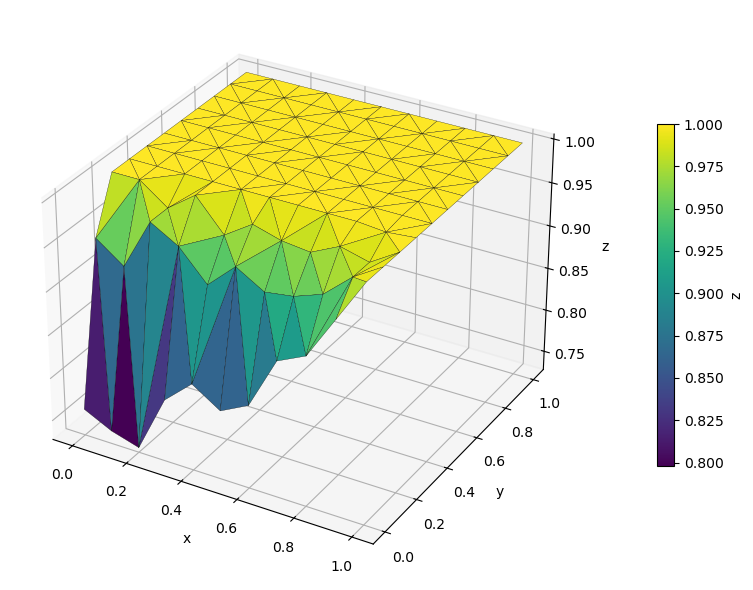

In [53]:
utils.plot_surface_from_points(ms, alphas, us)